In [30]:
import pandas as pd
import numpy as np

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

from feature_engine import discretisers as dsc

import networkx as nx
import pylab as plt
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_credit = pd.read_csv("german_credit.csv")

In [3]:
### Finding Missing values, checking if they are legitimate and applying apt transformation
df_credit.isnull().sum()

Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    183
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

In [4]:
### NaN is a valid field here implying no saving account

df_credit['Saving accounts'].value_counts()
df_credit['Saving accounts'].unique()

### So, replacing NaN with 'no account'
df_credit.loc[df_credit['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

### Replaced in df
df_credit['Saving accounts'].value_counts()
df_credit['Saving accounts'].unique()

### No NaNs anymore
df_credit.isnull().sum()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

little        603
no account    183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

array(['no account', 'little', 'quite rich', 'rich', 'moderate'],
      dtype=object)

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

### Understanding the ordinality of 'Credit History' and 'Job'

In [5]:
df_credit['Credit History'].value_counts() ### 0 to 4, credit history improves

2    530
4    293
3     88
1     49
0     40
Name: Credit History, dtype: int64

In [6]:
df_credit['Job'].value_counts() ### job improves from 0 to 3

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [7]:
df_credit.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,no account,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad


In [8]:
target = 'Risk'

### Lets make a list of numerical features which needs to be binned

In [9]:
### Lets say if a feature has more than 32 unique values, we will bin it
col_list = []
for col in df_credit.columns:
    print(col, ": ", len(df_credit[col].unique()))
    if(len(df_credit[col].unique()) > 32):
        col_list.append(col)

Credit History :  5
Age :  53
Gender :  2
Job :  4
Housing :  3
Saving accounts :  5
Credit amount :  921
Duration :  33
Purpose :  8
Risk :  2


### From above, we can see Age, Credit amount and Duration satisfy the criteria

In [10]:
num_bins = 3
disc = dsc.EqualFrequencyDiscretiser(q=num_bins, variables=col_list)
df_binned = disc.fit(df_credit[col_list])
equalfrequency_discretizer_dict = disc.binner_dict_
bin_df_equalfrequency = pd.DataFrame.from_dict(equalfrequency_discretizer_dict, orient = 'index')  

In [11]:
bin_df_equalfrequency

,0,1,2,3
Age,-inf,28.0,38.0,inf
Credit amount,-inf,1554.0,3368.0,inf
Duration,-inf,12.0,24.0,inf


### Lets make the final dataframe a little cleaner to understand the range of values it can take based on its min and max value

In [12]:
### Age has min and max as 19 and 75 respectively
min(df_credit['Age'].unique()), max(df_credit['Age'].unique())
bin_age = ['19 to 28', '28 to 38', '38 to 75']

(19, 75)

In [13]:
### Credit amount has min and max as 250 and 18424 respectively
min(df_credit['Credit amount'].unique()), max(df_credit['Credit amount'].unique())
bin_credit_amount = ['250 to 1554', '1554 to 3368', '3368 to 18424']

(250, 18424)

In [14]:
### Duration has min and max as 4 and 72 respectively
min(df_credit.Duration.unique()), max(df_credit.Duration.unique())
bin_duration = ['4 to 12', '12 to 24', '24 to 72']

(4, 72)

In [15]:
df_credit['Age'] = pd.cut(df_credit['Age'], 3, labels= bin_age)
df_credit['Credit amount'] = pd.cut(df_credit['Credit amount'], 3, labels= bin_credit_amount)
df_credit['Duration'] = pd.cut(df_credit['Duration'], 3, labels= bin_duration)

In [16]:
df_credit

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,38 to 75,male,2,own,no account,250 to 1554,4 to 12,radio/TV,good
1,2,19 to 28,female,2,own,little,250 to 1554,12 to 24,radio/TV,bad
2,4,28 to 38,male,1,own,little,250 to 1554,4 to 12,education,good
3,2,28 to 38,male,2,free,little,1554 to 3368,12 to 24,furniture/equipment,good
4,3,28 to 38,male,2,free,little,250 to 1554,4 to 12,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,19 to 28,female,1,own,little,250 to 1554,4 to 12,furniture/equipment,good
996,2,28 to 38,male,3,own,little,250 to 1554,12 to 24,car,good
997,2,28 to 38,male,2,own,little,250 to 1554,4 to 12,radio/TV,good
998,2,19 to 28,male,2,free,little,250 to 1554,12 to 24,radio/TV,bad


In [17]:
df_train = df_credit[:900]
df_test = df_credit[900:]
df_credit.shape
df_train.shape
df_test.shape

(1000, 10)

(900, 10)

(100, 10)

### Model Building and Parameter Learning

<Figure size 1080x720 with 0 Axes>

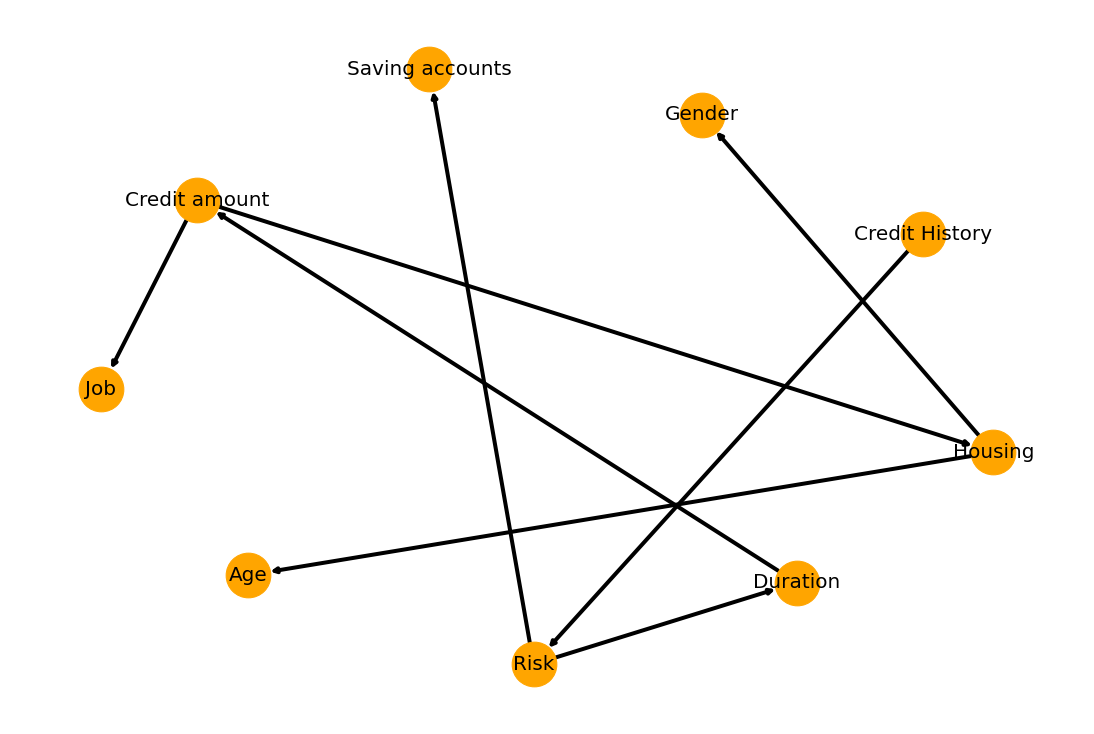

In [18]:
hc = HillClimbSearch(df_train, scoring_method=BicScore(df_train))
best_model = hc.estimate()
edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=2000, node_color="orange", width = 4, font_size = 20)
plt.show()

In [19]:
# Fitting the data to the model using Maximum Likelihood Estimator
model.fit(df_train, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

### As evident from the graph above, we can also find the parents and children

In [20]:
model.get_children(target)

['Duration', 'Saving accounts']

In [21]:
model.get_parents(target)

['Credit History']

### Joint distribution

In [22]:
print(infer.query(variables=[target, 'Gender'], joint= True))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 388.89it/s]

+------------+----------------+--------------------+
| Risk       | Gender         |   phi(Risk,Gender) |
+============+================+====================+
| Risk(bad)  | Gender(female) |             0.0931 |
+------------+----------------+--------------------+
| Risk(bad)  | Gender(male)   |             0.2047 |
+------------+----------------+--------------------+
| Risk(good) | Gender(female) |             0.2202 |
+------------+----------------+--------------------+
| Risk(good) | Gender(male)   |             0.4820 |
+------------+----------------+--------------------+


### Conditional distribution

In [23]:
print(infer.query(variables=[target], evidence={'Gender': 'male'}))
print(infer.query(variables=[target], evidence={'Gender': 'female'}))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 411.77it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2981 |
+------------+-------------+
| Risk(good) |      0.7019 |
+------------+-------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2971 |
+------------+-------------+
| Risk(good) |      0.7029 |
+------------+-------------+


In [24]:
print(infer.query(variables=['Gender'], evidence={target: 'bad'}))
print(infer.query(variables=['Gender'], evidence={target: 'good'}))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 501.71it/s]

+----------------+---------------+
| Gender         |   phi(Gender) |
+================+===============+
| Gender(female) |        0.3126 |
+----------------+---------------+
| Gender(male)   |        0.6874 |
+----------------+---------------+


Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 437.47it/s]


+----------------+---------------+
| Gender         |   phi(Gender) |
+================+===============+
| Gender(female) |        0.3136 |
+----------------+---------------+
| Gender(male)   |        0.6864 |
+----------------+---------------+


### Given the knowledge of credit history of the borrower, what can we infer about the risk associated with the profile

Improved credit history signals better credit worthiness

In [25]:
for i in [0,1,2,3,4]:
    print("Credit History:", i)
    print(infer.query(variables=[target], evidence = {'Credit History': i}))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.11it/s]

Credit History: 0



Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.35it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.6486 |
+------------+-------------+
| Risk(good) |      0.3514 |
+------------+-------------+
Credit History: 1
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.5238 |
+------------+-------------+
| Risk(good) |      0.4762 |
+------------+-------------+
Credit History: 2
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3192 |
+------------+-------------+
| Risk(good) |      0.6808 |
+------------+-------------+
Credit History: 3
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3165 |
+------------+-------------+
| Risk(good) |      0.6835 |
+------------+-------------+
Credit History: 4
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1710 |


### Saving Accounts

If saving accounts signify the richness quotient of the borrower, then as it goes up, the bad risk reduces. 

In [26]:
feat = 'Saving accounts'
list_range = ['little', 'moderate', 'rich', 'quite rich']

for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {feat: i}))

little


Eliminating: Duration:   0%|                                                                     | 0/7 [00:00<?, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3548 |
+------------+-------------+
| Risk(good) |      0.6452 |
+------------+-------------+
moderate
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3261 |
+------------+-------------+
| Risk(good) |      0.6739 |
+------------+-------------+
rich


Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.90it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1304 |
+------------+-------------+
| Risk(good) |      0.8696 |
+------------+-------------+
quite rich
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1273 |
+------------+-------------+
| Risk(good) |      0.8727 |
+------------+-------------+


### Duration

Loans with shorter duration are mostly repaid without default, the bad risk i.e. credit worthiness deteriorates as duration increases.
Note that it justifies the intuition that the longer the period, it induces more volatility into the system, where volatility might be construed as more risk 

In [27]:
### Effect of Duration on 'Credit Risk'
list_range = bin_duration
for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {'Duration': i}))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.37it/s]


4 to 12
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2561 |
+------------+-------------+
| Risk(good) |      0.7439 |
+------------+-------------+
12 to 24
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4439 |
+------------+-------------+
| Risk(good) |      0.5561 |
+------------+-------------+
24 to 72


Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 777.83it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4286 |
+------------+-------------+
| Risk(good) |      0.5714 |
+------------+-------------+


### Credit amount

Bad risk is maximum for high amount of credits borrowed

In [28]:
list_range = bin_credit_amount
for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {'Credit amount': i}))

Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 777.85it/s]

250 to 1554
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2842 |
+------------+-------------+
| Risk(good) |      0.7158 |
+------------+-------------+
1554 to 3368



Eliminating: Housing: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 778.16it/s]


+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3849 |
+------------+-------------+
| Risk(good) |      0.6151 |
+------------+-------------+
3368 to 18424
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3921 |
+------------+-------------+
| Risk(good) |      0.6079 |
+------------+-------------+
